In [1]:
# from config import CFG
from config import Config
from paso1_generar_datalimpia_distrito import datalimpia
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import pyproj
from sklearn.cluster import DBSCAN, KMeans
import math
import sys
import matplotlib.pyplot as plt
import contextily as ctx  # para añadir fondo de mapa
from scipy.spatial.distance import pdist,squareform

def normalizar_tot_reg(tot_reg: int) -> int:
    
    if tot_reg >= 1000:
        return 1000
    else:
        # redondea al múltiplo de 100 más cercano
        return math.floor(tot_reg/100)*100
    
class clusterizacion_distritos:
    def __init__(self,CFG,tot_reg):
        self.INPUT_CSV = CFG["naming"]["clean"].format(
            prefix=CFG["client_prefix"],
            datetime=CFG["now"]
        )

        self.OUTPUT_CSV = CFG["naming"]["cluster"].format(
            prefix=CFG["client_prefix"],
            datetime=CFG["now"]
        )
        self.VIA_JSON = CFG["cluster"]["vias_file"]  # "vias_Lima.geojson"
        self.BARRIER_METROS = CFG["cluster"].get("buffer_m", 50)
        self.ref_lat, self.ref_lon = CFG["cluster"]["reference_point"]
        self.MIN_POR_RUTA = CFG["cluster"]["min_size"]
        self.MAX_POR_RUTA = CFG["cluster"]["max_size"]
        self.MAX_ROUTES = CFG["cluster"]["max_routes"]
        self.EPS_METROS = CFG["cluster"].get("eps_metros", 500)
        # self.FUSION_DIST_MAX = CFG["cluster"].get("fusion_dist_max", 1000)
        self.FUSION_DIST_MAX = normalizar_tot_reg(tot_reg)
        self.gdf = None
        self.crs_wgs = "EPSG:4326"
        self.crs_metric = "EPSG:32718"  # UTM zona 18S (Perú)
        self.proj_to_metric = pyproj.Transformer.from_crs(self.crs_wgs, self.crs_metric, always_xy=True)
        
    def project(self,lons, lats):
        xs, ys = self.proj_to_metric.transform(lons, lats)
        return np.vstack([xs, ys]).T
    
    def carga_datos(self):
        try:
            df = pd.read_csv(self.INPUT_CSV)
        except FileNotFoundError:
            print(f"Error: no se encontró '{INPUT_CSV}'")
            sys.exit(1)
        if not {"ID", "Latitud", "Longitud"}.issubset(df.columns):
            raise RuntimeError("Faltan columnas 'ID','Latitud','Longitud' en el CSV.")
        # Convertir a GeoDataFrame
        self.gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df["Longitud"], df["Latitud"]),
            crs=self.crs_wgs
        ).to_crs(self.crs_metric)
        
        # return gdf_islas
    def carga_islas(self):
        self.carga_datos()

        vias = gpd.read_file(self.VIA_JSON).to_crs(self.crs_metric)
        barreras = vias.buffer(self.BARRIER_METROS)
        barreras_union = unary_union(barreras)  # Gráfico de todas las barreras combinadas

        # ======= Crear "islas" separadas por avenidas o calles principales =======
        # Crear un área total alrededor de las coordenadas originales
        area_total = self.gdf.unary_union.buffer(2000)
        islas = area_total.difference(barreras_union)  # Recortar con barreras

        # Convertir a GeoDataFrame
        gdf_islas = gpd.GeoDataFrame(geometry=[islas], crs=self.crs_metric).explode(index_parts=False)
        gdf_islas.reset_index(drop=True, inplace=True)

        return gdf_islas

    def split_cluster(self,df_cluster):
        """Fragmenta un cluster grande usando DBSCAN"""
        
        if len(df_cluster) <= (self.MAX_POR_RUTA+12):
            # print("cluster en rango aceptable")
            return df_cluster
        # print(len(df_cluster))
        # Aplicar DBSCAN para fragmentar
        # if len(df_cluster) == 192:
        if len(df_cluster) > 180:
            n_ = int(len(df_cluster) / self.MAX_POR_RUTA)
            coords = self.project(
                df_cluster["Longitud"].to_numpy(),
                df_cluster["Latitud"].to_numpy()
            )
            kmeans = KMeans(n_clusters=n_, random_state=42, n_init=10)
            labels = kmeans.fit_predict(coords)

            # Asignar clusters nuevos con sufijo único
            base_id = df_cluster["cluster"].max() + 1
            df_cluster = df_cluster.copy()
            df_cluster["cluster"] = base_id + labels

            print(f"[KMeans] Cluster de 192 puntos dividido en 3 subclusters.")
            return df_cluster
        
        if len(df_cluster) < 180:
            coords = self.project(
                df_cluster["Longitud"].to_numpy(),
                df_cluster["Latitud"].to_numpy()
            )
            kmeans = KMeans(n_clusters=2, random_state=42, n_init=20)
            labels = kmeans.fit_predict(coords)

            # Asignar clusters nuevos con sufijo único
            base_id = df_cluster["cluster"].max() + 1
            df_cluster = df_cluster.copy()
            df_cluster["cluster"] = base_id + labels

            print(f"[KMeans] Cluster de 192 puntos dividido en 3 subclusters.")
            return df_cluster
        
        
        print(f"puntos antes: {len(df_cluster)} | clusters antes: {df_cluster['cluster'].nunique()}")
        
        coords = self.project(df_cluster["Longitud"].to_numpy(), df_cluster["Latitud"].to_numpy())
        labels = DBSCAN(eps=100, min_samples=1).fit_predict(coords)  # Usamos DBSCAN para fragmentar el cluster

        df_cluster["cluster"] = df_cluster["cluster"].max() + 1 + labels
        print(f"puntos después: {len(df_cluster)} | clusters después: {df_cluster['cluster'].nunique()}")
        # print(df_cluster["cluster"].value_counts())
        # print(len(df_cluster))
        return df_cluster

    def merge_small_clusters(self,df):
        """Fusiona clusters pequeños en uno solo si están cerca de otro cluster"""
        df = df.copy()
        changed = True
        while changed:
            changed = False
            # counts = df["cluster"].value_counts()
            counts = (
                df.groupby(["isla_id", "cluster"])
                  .size()
                  .reset_index(name="count")
            )
    
            small_clusters = [
                (row.isla_id, row.cluster)
                for _, row in counts.iterrows()
                if row["count"] < self.MIN_POR_RUTA
            ]
                      
            # print(f"cantidades: {counts}")
            # small_clusters = counts[counts < self.MIN_POR_RUTA].index.tolist()
            if not small_clusters:
                break

            centroids = {
                cl: self.project(
                    df[df["cluster"] == cl]["Longitud"].to_numpy(),
                    df[df["cluster"] == cl]["Latitud"].to_numpy()
                ).mean(axis=0)
                for cl in df["cluster"].unique()
            }

            for cl in small_clusters:
                if cl not in centroids:
                    continue
                # Calcular la distancia entre el cluster pequeño y otros clusters
                distances = {
                    other: np.linalg.norm(centroids[cl] - centroids[other])
                    for other in centroids if other != cl
                }
                # print(distances)
                if not distances:
                    continue
                # Encontrar el cluster más cercano
                nearest = min(distances, key=distances.get)
                # print(f'distancia minima del cluster: {nearest}')
                # Si la distancia es menor al umbral, fusionar los clusters
                if distances[nearest] <= self.FUSION_DIST_MAX:
                    # df = df.copy()
                    df.loc[df["cluster"] == cl, "cluster"] = nearest
                    changed = True
                    break  # Salir y volver a verificar los cambios
        return df
    
    def separar_puntos_alejados(self, df):
        """
        Revisa cada cluster de df y separa:
          - Puntos cuya distancia mínima a cualquier otro del mismo cluster sea > dist_umbral.
          - De esos alejados, agrupa si están a <= dist_grupo.
          - Los que quedan solos, se vuelven clusters individuales.

        Parámetros:
        -----------
        dist_umbral : float
            Distancia mínima (m) para considerar un punto como 'alejado'.
        dist_grupo : float
            Distancia máxima (m) entre alejados para considerarlos un mismo grupo.
        """
        dist_umbral=300
        dist_grupo=120
        
        nuevo_df_list = []
        contador_nuevos = 0  # para asignar IDs únicos

        for (isla_id, cluster_id), grupo in df.groupby(["isla_id", "cluster"]):
            if len(grupo) < 2:
                nuevo_df_list.append(grupo)
                continue
            
            # Coordenadas en metros
            coords = self.project(
                grupo["Longitud"].to_numpy(),
                grupo["Latitud"].to_numpy()
            )

            # Matriz de distancias NxN
            dist_matrix = squareform(pdist(coords))
            np.fill_diagonal(dist_matrix, np.inf)

            # Distancia mínima de cada punto a otro
            min_dists = dist_matrix.min(axis=1)

            # Más alejados que el umbral
            alejados_mask = min_dists > dist_umbral
            # print(alejados_mask)
            inliers = grupo.loc[~alejados_mask].copy()
            outliers = grupo.loc[alejados_mask].copy()

            # Mantener inliers en el cluster original
            if not inliers.empty:
                nuevo_df_list.append(inliers)

            # Procesar alejados
            if outliers.empty:
                continue
            elif len(outliers) == 1:
                # Alejado único
                outliers = outliers.copy()
                outliers["cluster"] = f"{cluster_id}_iso{contador_nuevos}"
                contador_nuevos += 1
                nuevo_df_list.append(outliers)
            else:
                # Agrupar alejados entre sí
                coords_out = self.project(
                    outliers["Longitud"].to_numpy(),
                    outliers["Latitud"].to_numpy()
                )
                labels = DBSCAN(eps=dist_grupo, min_samples=1).fit_predict(coords_out)

                for lab, subgrp in outliers.groupby(labels):
                    subgrp = subgrp.copy()
                    subgrp["cluster"] = f"{cluster_id}_g{contador_nuevos}"
                    contador_nuevos += 1
                    nuevo_df_list.append(subgrp)

        return pd.concat(nuevo_df_list, ignore_index=True)

    
    def verificar_cluster_aislado(self,df_final):
        # Nueva validación: Detectar y separar puntos o grupos alejados en cada cluster
        nuevo_df_list = []
        MAX_INTRA_DIST = 1000
        MAX_GROUP_DIST = 200
        # MAX_INTRA_DIST = 300
        # MAX_GROUP_DIST = 100
        
        
        for (isla_id, cluster_id), grupo in df_final.groupby(["isla_id", "cluster"]):
            # Obtener coordenadas métricas (usando tu método project)
            coords = self.project(grupo["Longitud"].to_numpy(), grupo["Latitud"].to_numpy())

            # Calcular centroide del cluster
            centroid = coords.mean(axis=0)

            # Calcular distancias euclidianas de cada punto al centroide
            dists = np.linalg.norm(coords - centroid, axis=1)
            print(f'isla: {isla_id} - cluster: {cluster_id} - distancia: {dists[0]}')
            # Identificar índices de puntos alejados y no alejados
            alejados_idx = np.where(dists > MAX_INTRA_DIST)[0]
            no_alejados_idx = np.where(dists <= MAX_INTRA_DIST)[0]

            # Mantener el cluster original solo con puntos no alejados
            grupo_original = grupo.iloc[no_alejados_idx].copy()
            nuevo_df_list.append(grupo_original)

            if len(alejados_idx) == 0:
                continue
            elif len(alejados_idx) == 1:
                # Un solo punto alejado: asignar a nuevo cluster
                nuevo_grupo = grupo.iloc[alejados_idx].copy()
                nuevo_grupo["cluster"] = f"{cluster_id}_outlier"
                nuevo_df_list.append(nuevo_grupo)
            else:
                # Múltiples puntos alejados: calcular distancia máxima pairwise entre ellos
                coords_alej = coords[alejados_idx]
                max_dist_alej = pdist(coords_alej).max() if len(coords_alej) > 1 else 0

                if max_dist_alej <= MAX_GROUP_DIST:
                    # Están cerca: asignar a un nuevo cluster unido
                    nuevo_grupo = grupo.iloc[alejados_idx].copy()
                    nuevo_grupo["cluster"] = f"{cluster_id}_group"
                    nuevo_df_list.append(nuevo_grupo)
                else:
                    # No están cerca: asignar cada uno a un cluster individual
                    for i, idx in enumerate(alejados_idx):
                        nuevo_grupo = grupo.iloc[[idx]].copy()
                        nuevo_grupo["cluster"] = f"{cluster_id}_outlier_{i}"
                        nuevo_df_list.append(nuevo_grupo)

        # Reconstruir df_final con los cambios
        df_final = pd.concat(nuevo_df_list)
        return df_final

    
    def clusterizacion_DBSCAN(self):
        sede_xy = self.project(np.array([self.ref_lon]), np.array([self.ref_lat]))[0]
        gdf_islas = self.carga_islas()
        # if gdf_islas:
        #     print("No se cargaron las islas")
        all_results = []
        cluster_id = 0
        # print(f'imprimiendo gdf_islas.iterrows: {gdf_islas.iterrows()}')
        numero_de_filas = len(self.gdf)
        
        if numero_de_filas > 90 and numero_de_filas <= 120:
            print(f"Saltando DBSCAN (solo {numero_de_filas} puntos). Se aplica KMeans con 2 clusters.")
            df_final = self.gdf.copy()
            coords = self.project(df_final["Longitud"].to_numpy(), df_final["Latitud"].to_numpy())

            kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
            labels = kmeans.fit_predict(coords)

            df_final["isla_id"] = 0
            df_final["cluster"] = labels
            
        elif numero_de_filas > 120:
            for _, isla in gdf_islas.iterrows():

                puntos_isla = self.gdf[self.gdf.geometry.within(isla.geometry)]
                if puntos_isla.empty:
                    # print("no hay puntos en las islas")
                    continue
                puntos_isla = puntos_isla.copy() ##Para evitar warnings
                puntos_isla["isla_id"] = _

                coords = self.project(puntos_isla["Longitud"].to_numpy(), puntos_isla["Latitud"].to_numpy())
                labels = DBSCAN(eps=200, min_samples=2).fit_predict(coords)  ## epsilon puede cambiar
                puntos_isla["cluster"] = labels + cluster_id

                cluster_id = puntos_isla["cluster"].max() + 1

                # Fragmentación de clusters grandes
                puntos_isla = pd.concat([self.split_cluster(puntos_isla[puntos_isla["cluster"] == cl]) for cl in puntos_isla["cluster"].unique()])
                puntos_isla = self.merge_small_clusters(puntos_isla)
                all_results.append(puntos_isla)

            df_final = pd.concat(all_results)
        
        else:
            df_final = self.gdf.copy()
            df_final["isla_id"] = 0
            df_final["cluster"] = 0
        
        
        #======Fragmentamos los clusters que sobrepasen el maximo de puntos permitido si es que los hubiera
        nuevo_df_list = []
        max_size = self.MAX_POR_RUTA + 10  #80  

        for cluster_id, grupo in df_final.groupby("cluster"):
            if len(grupo) > max_size:
                # Calcular cuántos subclusters se necesitan
                k = math.ceil(len(grupo) / ((self.MIN_POR_RUTA+self.MAX_POR_RUTA)/2))   #50
                # KMeans en coordenadas métricas
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(grupo[["Longitud", "Latitud"]])
                # Generar nuevo ID de cluster combinando el original y el sub-ID
                grupo = grupo.copy()
                grupo["cluster"] = [f"{cluster_id}_{sub}" for sub in labels]
                nuevo_df_list.append(grupo)
            else:
                nuevo_df_list.append(grupo)

        df_final = pd.concat(nuevo_df_list)
        
        
        # df_final = self.separar_puntos_alejados(df_final)
        df_final = self.verificar_cluster_aislado(df_final)
        
        
        
        #======Eliminamos los clusters mas pequeños (MIN_POR_RUTA - 10)
        umbral_min = self.MIN_POR_RUTA - 10  #Mantendremos clusters entre 40 y 50
        # counts = df_final["cluster"].value_counts()
        counts = (
            df_final
            .groupby(["isla_id", "cluster"])
            .size()  # cuenta filas
            .reset_index(name="count")
        )
        # clusters_validos = counts[counts >= umbral_min].index
        clusters_validos = counts[counts["count"] >= umbral_min]
        clusters_validos_list = list(
            zip(clusters_validos["isla_id"], clusters_validos["cluster"])
        )
        # print(f"cluster validos: {clusters_validos}")
        # df_final = df_final[df_final["cluster"].isin(clusters_validos)].copy()
        
        df_prime = df_final.copy()
        
        df_final = df_final[
            pd.Series(zip(df_final["isla_id"], df_final["cluster"]),index=df_final.index)
              .isin(clusters_validos_list)
        ]
        
    
    
    
        # Asignar rutas basadas en centroides
        df_final["Ruta"] = None
        ruta_counter = 1  # Contador global de rutas

        centroids = {}
        for isla_id in sorted(df_final["isla_id"].unique()):
            sub = df_final[df_final["isla_id"] == isla_id].copy()

            # Calcular el centroide de cada cluster en la isla
            for cl in sub["cluster"].unique():
                centroid = self.project(
                    sub[sub["cluster"] == cl]["Longitud"].to_numpy(),
                    sub[sub["cluster"] == cl]["Latitud"].to_numpy()
                ).mean(axis=0)
                centroids[(isla_id, cl)] = centroid

        # Calcular la distancia de cada ruta al punto de referencia (distribuidor)
        dist_map = {}
        for (isla_id, cluster_id), centroid in centroids.items():
            dist_map[(isla_id, cluster_id)] = np.linalg.norm(centroid - sede_xy)

        # Ordenar los clusters por proximidad al punto de referencia
        sorted_clusters = sorted(dist_map.items(), key=lambda x: x[1])

        # Seleccionar las rutas
        selected_clusters = sorted_clusters[:self.MAX_ROUTES]  # Seleccionamos las 12 rutas más cercanas al punto de referencia

        # Asignar las rutas más cercanas en un orden estricto y secuencial
        ruta_counter = 1
        for (isla_id, cluster_id), _ in selected_clusters:
            mask = (df_final["isla_id"] == isla_id) & (df_final["cluster"] == cluster_id)
            num_points = len(df_final[mask])
            df_final.loc[mask, "Ruta"] = f"Ruta {ruta_counter}"
            print(f"Asignada Ruta {ruta_counter} al cluster {cluster_id} en isla {isla_id}, puntos: {num_points}, distancia: {_:.2f} m")
            # df_final.loc[(df_final["isla_id"] == isla_id) & (df_final["cluster"] == cluster_id), "Ruta"] = f"Ruta {ruta_counter}"
            ruta_counter += 1
        
        # Debugging: Verificar puntos no asignados
        # unassigned_points = df_final[df_final["Ruta"].isnull()]
        # if not unassigned_points.empty:
        #     print(f"Advertencia: {len(unassigned_points)} puntos no asignados a ninguna ruta:")
        #     print(unassigned_points[["isla_id", "cluster", "Longitud", "Latitud"]].head())

            
            
        # Eliminar cualquier ruta que no esté dentro de las 12 más cercanas
        df_final = df_final[df_final["Ruta"].notnull()]
        # counts_final = df_final["Ruta"].value_counts()
        # df_final = df_final[df_final["Ruta"].isin(counts_final[counts_final >= umbral_min].index)]
        
        df_prime = df_final.copy()
        
        # ======= Guardar resultados =======
        df_final.drop(columns=["cluster", "geometry"]).to_csv(self.OUTPUT_CSV, index=False)
        print(f"✔ Clusterización completada respetando avenidas. Archivo: '{self.OUTPUT_CSV}'")

        # Crear GeoDataFrame con sistema proyectado
        gdf_final = gpd.GeoDataFrame(
            df_final,
            geometry=gpd.points_from_xy(df_final["Longitud"], df_final["Latitud"]),
            crs=self.crs_wgs
        ).to_crs(epsg=3857)  # Web Mercator (requerido por contextily)

        fig, ax = plt.subplots(figsize=(10, 10))

        # Plotear los clusters por "Ruta"
        gdf_final.plot(column="Ruta", ax=ax, legend=True, cmap="tab20", markersize=30)


        # gdf_sede.plot(ax=ax, color="red", marker="*", markersize=150, label="Sede")

        # Agregar mapa base
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        # Personalización
        ax.set_title("Visualización geográfica de Clusters por Ruta", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        # plt.savefig("clusters_por_ruta.jpg")
        plt.show()
        
        return df_prime

Configuraciones de config.json aplicadas exitosamente....


/home/78289@bcrp.gob.pe/Pruebas_practicante/Proyectos/MML/CLUSTERIZATION/PuentePiedra/paso1_generar_datalimpia_distrito.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.INPUT_CSV)


Registros sin lat/lon válidos eliminados: 83
Filtro Departamentos: se conservaron 44611 de 123332 puntos.
Filtro Provincias: se conservaron 44611 de 44611 puntos.
Filtro Distritos: se conservaron 3231 de 44611 puntos.
✔ Generado 'DIMORISAC S.A.C._Ate_Datalimpia_20250817.csv' con 3231 registros válidos.


Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field ref: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5
Skipping field junction: unsupported OGR type: 5
/tmp/ipykernel_2637159/3768844291.py:79: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_total = self.gdf.unary_union.buffer(2000)


[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
[KMeans] Cluster de 192 puntos dividido en 3 subclusters.
isla: 2 - cluster: 0 - distancia: 470.4247164704389
isla: 4 - cluster: 0 - distancia: 0.0
isla: 4 - cluster: 4 - distancia: 656.5508758579361
isla: 4 - cluster: 2_0 - distancia: 491.98110998833664
isla: 4 - cluster: 2_1 - distancia: 110.06190325381509
isla: 4 - cluster: 3_0 - distancia: 585.886217883196
isla: 4 - cluster: 3_1 - distancia: 309.6944745725845
isla: 8 - cluster: 4 - distancia: 34.443817211393366
isla: 8 - cluster: 5 - distancia: 75.66863028850692
isla: 8 - cluster: 6 - distancia: 12.856286375186256
isla: 8 - cluster: 

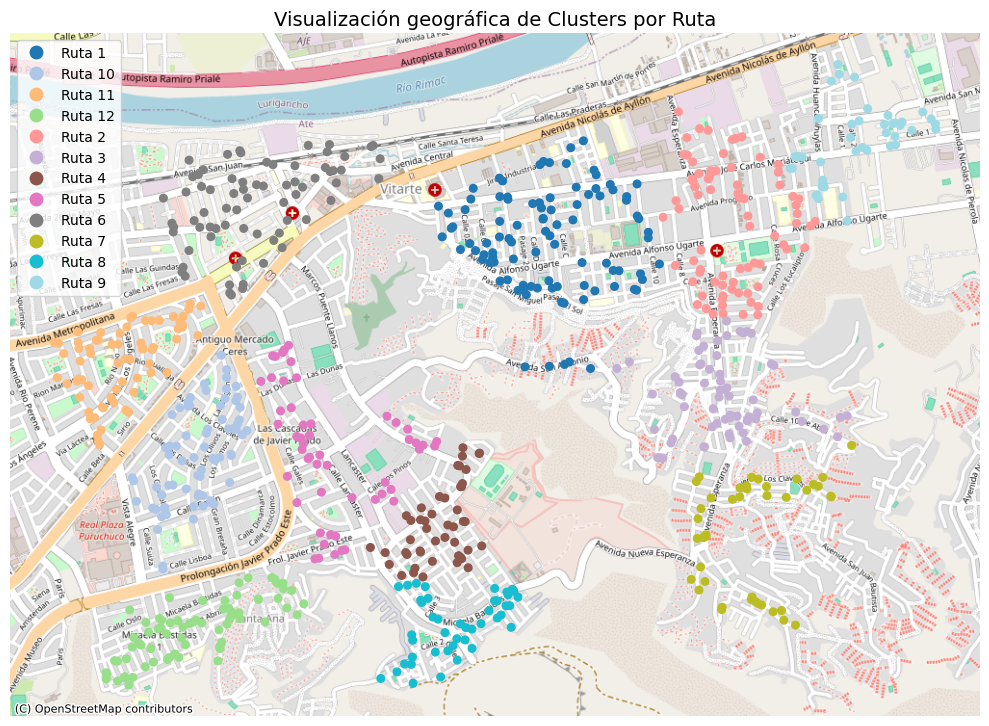

In [2]:
if __name__ == "__main__":
    instancia = Config()
    # CFG = instancia.modify_config()
    CFG = instancia.apli_config()
    
    nueva_data = datalimpia(CFG)
    nueva_data.transform_data_original()
    
    clusters = clusterizacion_distritos(CFG,nueva_data.totalregistros)
    df_prime = clusters.clusterizacion_DBSCAN()

In [4]:
import sys
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import pyproj
from config import Config

instancia = Config()
CFG = instancia.apli_config()
rutas = poligonos(CFG)
rutas.ejecucion()

Configuraciones de config.json aplicadas exitosamente....
✔ Generados 12 polígonos (sin solapamientos):
Archivo guardado en 'DIMORISAC S.A.C._Carabayllo_Poligonos_20250817.geojson'


In [2]:
from paso5_poligonos_puntos_publicos import publicos_poligonos
from config import Config
instancia = Config()
# CFG = instancia.modify_config()
CFG = instancia.apli_config()
instancia_pub = publicos_poligonos(CFG)
instancia_pub.ejecucion()

Configuraciones de config.json aplicadas exitosamente....
▶ Leyendo rutas de DIMORISAC S.A.C._Carabayllo_Rutas_20250817.csv
▶ Guardando puntos públicos en DIMORISAC S.A.C._Carabayllo_PuntosPublicos_20250817.geojson
▶ Leyendo polígonos de DIMORISAC S.A.C._Carabayllo_Poligonos_20250817.geojson
▶ Guardando polígonos públicos en DIMORISAC S.A.C._Carabayllo_PoligonosPublicos_20250817.geojson
Archivos públicos preparados exitosamente.


In [39]:
df_prime = pd.read_csv('df_final.csv')

In [44]:
# umbral_min = 50 - 10  #Mantendremos clusters entre 40 y 50
# counts = df_prime["cluster"].value_counts()
# clusters_validos = counts[counts >= umbral_min].index
# df_p = df_prime[df_prime["cluster"].isin(clusters_validos)]
# df_prime["cluster"].value_counts()
df_prime = pd.read_csv('prime.csv')
umbral_min = 40  #Mantendremos clusters entre 40 y 50
# counts = df_final["cluster"].value_counts()
counts = (
    df_prime
    .groupby(["isla_id", "cluster"])
    .size()  # cuenta filas
    .reset_index(name="count")
)
# clusters_validos = counts[counts >= umbral_min].index
clusters_validos = counts[counts["count"] >= umbral_min]
clusters_validos_list = list(
    zip(clusters_validos["isla_id"], clusters_validos["cluster"])
)
df_final = df_prime[
    pd.Series(
        list(zip(df_prime["isla_id"], df_prime["cluster"])),
        index=df_prime.index
    ).isin(clusters_validos_list)
]

In [45]:
df_final

,Director,Gerencia,Dirección Distribución,Gerencia Distribución,Clasificacion RTM,Sub Canal,Canal,Código CD,Nombre CD,Cod Cliente,...,Documento Identidad,Codigo RUC,País,ID,Departamentos,Provincias,Distritos,geometry,isla_id,cluster
0,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega Bar,Socializando,BK35,CD Cono Norte,279501.0,...,NaN,1.006837e+10,Perú,3841,LimaProvince,Lima,Comas,POINT (276251.8529736679 8683126.849912819),1,0
1,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega De Barrio Tradicional,Consumo En Casa,BK35,CD Cono Norte,1097980.0,...,NaN,1.032304e+10,Perú,3842,LimaProvince,Lima,Comas,POINT (276213.6749588897 8683205.791980457),1,0
2,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega Bar,Socializando,BK35,CD Cono Norte,279613.0,...,6897623.0,NaN,Perú,3843,LimaProvince,Lima,Comas,POINT (276229.74133999576 8683169.83934504),1,0
3,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega De Barrio Tradicional,Consumo En Casa,BK35,CD Cono Norte,279245.0,...,NaN,1.010385e+10,Perú,3844,LimaProvince,Lima,Comas,POINT (276297.4531230846 8683149.31705858),1,0
4,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega Bar,Socializando,BK35,CD Cono Norte,1097504.0,...,7166501.0,NaN,Perú,6114,LimaProvince,Lima,Comas,POINT (277027.323495764 8684390.317298446),1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega De Barrio Tradicional,Consumo En Casa,BK35,CD Cono Norte,280056.0,...,NaN,1.007221e+10,Perú,185757,LimaProvince,Lima,Comas,POINT (274862.88306556013 8680153.337399818),10,76
2714,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega De Barrio Tradicional,Consumo En Casa,BK35,CD Cono Norte,279001.0,...,NaN,1.006051e+10,Perú,185762,LimaProvince,Lima,Comas,POINT (274963.2427776523 8680429.60439976),10,76
2715,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega De Barrio Tradicional,Consumo En Casa,BK35,CD Cono Norte,915439.0,...,NaN,1.547211e+10,Perú,185763,LimaProvince,Lima,Comas,POINT (275090.90950640815 8680536.3374329),10,76
2716,Pe Dir Lima Metrop,Pe Ger Lm Lima 02,Lima Centro Norte,Ger. Distr. Cono Norte,Distribucion Directa,Bodega De Barrio Tradicional,Consumo En Casa,BK35,CD Cono Norte,278983.0,...,NaN,1.006120e+10,Perú,185764,LimaProvince,Lima,Comas,POINT (275083.51122979645 8680374.069692146),10,76


In [31]:
from config import Config
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import pyproj
from sklearn.cluster import DBSCAN, KMeans
import math
import sys

instancia = Config()
CFG = instancia.modify_config()

# ======= CONFIGURACIÓN vía config.json =======
INPUT_CSV = CFG["naming"]["clean"].format(
    prefix=CFG["client_prefix"],
    datetime=CFG["now"]
)
OUTPUT_CSV = CFG["naming"]["cluster"].format(
    prefix=CFG["client_prefix"],
    datetime=CFG["now"]
)
VIA_JSON = CFG["cluster"]["vias_file"]  # "vias_PERU.geojson"
BARRIER_METROS = CFG["cluster"].get("buffer_m", 50)
ref_lat, ref_lon = CFG["cluster"]["reference_point"]
MIN_POR_RUTA = CFG["cluster"]["min_size"]
MAX_POR_RUTA = CFG["cluster"]["max_size"]
MAX_ROUTES = CFG["cluster"]["max_routes"]
EPS_METROS = CFG["cluster"].get("eps_metros", 500)
FUSION_DIST_MAX = CFG["cluster"].get("fusion_dist_max", 1000)

# ======= Proyecciones =======
crs_wgs = "EPSG:4326"
crs_metric = "EPSG:32718"  # UTM zona 18S (Perú)
proj_to_metric = pyproj.Transformer.from_crs(crs_wgs, crs_metric, always_xy=True)

def project(lons, lats):
    xs, ys = proj_to_metric.transform(lons, lats)
    return np.vstack([xs, ys]).T

# ======= Cargar datos =======
try:
    df = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: no se encontró '{INPUT_CSV}'")
    sys.exit(1)
if not {"ID", "Latitud", "Longitud"}.issubset(df.columns):
    raise RuntimeError("Faltan columnas 'ID','Latitud','Longitud' en el CSV.")
    

# Convertir a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitud"], df["Latitud"]),
    crs=crs_wgs
).to_crs(crs_metric)

# ======= Cargar avenidas y generar barreras =======
vias = gpd.read_file(VIA_JSON).to_crs(crs_metric)
barreras = vias.buffer(BARRIER_METROS)
barreras_union = unary_union(barreras)  # Gráfico de todas las barreras combinadas

# ======= Crear "islas" separadas por avenidas o calles principales =======
# Crear un área total alrededor de las coordenadas originales
area_total = gdf.unary_union.buffer(2000)
islas = area_total.difference(barreras_union) 

Cargando configuración inicial...
Configuraciones de config.json aplicadas exitosamente....

Modificando configuraciones. Presione Enter para mantener el valor actual.


Cliente prefix actual: DIMORISAC S.A.C._Carabayllo
Nuevo valor (texto):  


Cliente prefix sin cambios: DIMORISAC S.A.C._Carabayllo


Nuevo distrito:  


Distritos sin cambios: ['Carabayllo']


Max routes actual: 12
Nuevo valor (número entero positivo):  


Max routes sin cambios
Punto de referencia actual: [-11.873746, -77.028021]


Nuevo punto de referencia (lat,lon, ej: -11.8955,-77.0679):  


Punto de referencia sin cambios: [-11.873746, -77.028021]
Maxima distancia para combinar clusters proximos: 1000


Digite la nueva distancia de tolerancia para los clusters:  


Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field ref: unsupported OGR type: 5


Distancia sin cambios: 1000
Configuración actualizada guardada en config.json exitosamente.


/tmp/ipykernel_1462216/1993139242.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_total = gdf.unary_union.buffer(2000)


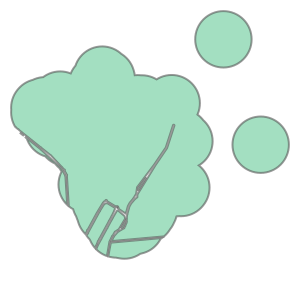

In [32]:
islas

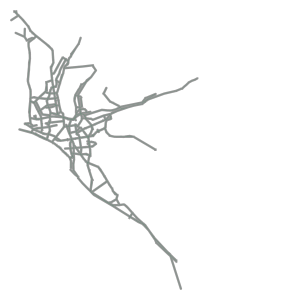

In [33]:
barreras_union

In [ ]:
instancia = Config()
CFG = instancia.modify_config()

nueva_data = datalimpia(CFG)
nueva_data.transform_data_original()

In [ ]:
clusters = clusterizacion_distritos(CFG,nueva_data.totalregistros)
clusters.clusterizacion_DBSCAN()